# Reproduce numerical instability in ResNet-50 using zennit's LRP

755226.0625


tensor(False)

torch.return_types.aminmax(
min=tensor(-7540.4922),
max=tensor(2985.0886))


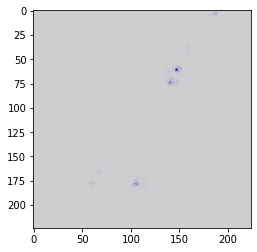

In [3]:
import cv2
import numpy
import torch
from matplotlib import pyplot as plt
from torchvision.models import resnet50
from zennit.composites import EpsilonGammaBox
from zennit.image import imgify
from zennit.torchvision import ResNetCanonizer

# use the gpu if requested and available, else use the cpu
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')


class BatchNormalize:
    def __init__(self, mean, std, device=None):
        self.mean = torch.tensor(mean, device=device)[None, :, None, None]
        self.std = torch.tensor(std, device=device)[None, :, None, None]

    def __call__(self, tensor):
        return (tensor - self.mean) / self.std


# mean and std of ILSVRC2012 as computed for the torchvision models
norm_fn = BatchNormalize((0.485, 0.456, 0.406),
                         (0.229, 0.224, 0.225), device=device)

batch_size = 1
# the maximal input shape, needed for the ZBox rule
shape = (batch_size, 3, 224, 224)

# the highest and lowest pixel values for the ZBox rule
low = norm_fn(torch.zeros(*shape, device=device))
high = norm_fn(torch.ones(*shape, device=device))


model = resnet50(pretrained=True)
model.eval()

# create the composite from the name map
composite = EpsilonGammaBox(low=-high, high=high, canonizers=[ResNetCanonizer()])

R = None
with composite.context(model) as modified_model:
    # compute attribution
    # Returns a numpy array in BGR color space, not RGB
    img = cv2.imread('../../../data/castle.jpg')


    # Convert from BGR to RGB color space
    img = img[..., ::-1]

    # img.shape is (224, 224, 3), where 3 corresponds to RGB channels
    # Divide by 255 (max. RGB value) to normalize pixel values to [0,1]
    img = img/255.0
    
    data = norm_fn(
        torch.FloatTensor(
            img[numpy.newaxis].transpose([0, 3, 1, 2])*1
        )
    )
    data.requires_grad = True

    output = modified_model(data)
    output[0].max().backward()

    # print absolute sum of attribution
    print(data.grad.abs().sum().item())

    # relevance scores
    R = data.grad

    display(R.isnan().any())

    # show maximum and minimum attribution
    print(torch.aminmax(R))

    heatmap = imgify(
        R.detach().cpu().sum(1),
        symmetric=True,
        grid=True,
        cmap='seismic',
    )
    
    plt.imshow(heatmap)